<h1> Parameter Tunning 
    
    Look at different steps & batch sizes
    
    (6 months of data used)

# Importing libraries:

In [30]:
!pip install pandas
!pip install sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data; set X and y; fill nan values and split in test, training and validation data:

In [31]:
# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# for later use
features_num = 15

# 2018 data
data = data.loc[data.index > 2018070000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values
data.fillna(method = 'ffill', inplace = True)

# divide features and labels
X = data.iloc[:, 0:15] .values # turns it into an array
y = data.loc[:, 'Offers'].values # turns it into an array

from sklearn.model_selection import train_test_split

# divide data into train and test 
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size = 0.15, shuffle=False)

# divide data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
         X_train, y_train, test_size = 0.3, shuffle=False)

# Apply feature scaling:

In [32]:
from sklearn.preprocessing import MinMaxScaler

# feature scaling 
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Importing the Keras libraries and packages:

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
import time

# empty list to append metric values
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []
time_count = []

# Prepare of data according to LSTM needs,  create regressor & tune:

In [34]:
# parameters
# steps = 96
# n_hidden = 1
units = 20
# batch_size = 96

from sklearn.model_selection import ParameterGrid
parameters = {'steps': [48, 96, 144, 336],
              'batch_size': [100, 150, 200, 250]}

all_param = ParameterGrid(parameters)

for i in range(len(all_param)):
    start_time = time.time()
    
    # import data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

    # for later use
    features_num = 15

    # 2018 data
    data = data.loc[data.index > 2018070000, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)

    # fill nan values
    data.fillna(method = 'ffill', inplace = True)

    # divide features and labels
    X = data.iloc[:, 0:15] .values # turns it into an array
    y = data.loc[:, 'Offers'].values # turns it into an array

    from sklearn.model_selection import train_test_split

    # divide data into train and test 
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.15, shuffle=False)

    # divide data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
             X_train, y_train, test_size = 0.3, shuffle=False)
    
    # set parameters right
    steps = all_param[i]['steps']
    batch_size = all_param[i]['batch_size']
    
    # function to split data into correct shape for RNN
    def split_data(X, y, steps):
        X_, y_ = list(), list()
        for i in range(steps, len(y)):
            X_.append(X[i - steps : i, :])
            y_.append(y[i]) 
        return np.array(X_), np.array(y_)

    X_train, y_train = split_data(X_train, y_train, steps)
    X_test, y_test = split_data(X_test, y_test, steps)
    X_val, y_val = split_data(X_val, y_val, steps)

    # function to cut data set so it can be divisible by the batch_size
    def cut_data(data, batch_size):
         # see if it is divisivel
        condition = data.shape[0] % batch_size
        if condition == 0:
            return data
        else:
            return data[: -condition]
        
    # design the LSTM
    def regressor_tunning(kernel_initializer = 'he_normal',
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
        # no hidden layer
        model.add(Dense(1, activation='linear'))
        model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = 'Adamax')
        return model

    model = regressor_tunning()

    # apply patience callback
    early_stopping = EarlyStopping(monitor='mse', patience=10)

    # fitting the LSTM to the training set
    history = model.fit(cut_data(X_train, batch_size),
                        cut_data(y_train, batch_size), 
                        batch_size = batch_size, 
                        epochs = 100,
                        shuffle = False, 
                        validation_data = (cut_data(X_val, batch_size), cut_data(y_val, batch_size)),
                        callbacks = early_stopping)

    X_test = cut_data(X_test, batch_size)
    y_test = cut_data(y_test, batch_size)

    # make new predicitons with test set
    y_pred = model.predict(cut_data(X_test, batch_size), batch_size = batch_size)

    # plot the training progression
    #plt.plot(history.history['val_loss'], label = 'train')
    #plt.plot(history.history['val_loss'], label = 'test')
    #plt.legend()
    #plt.show()

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525

    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)

    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================

    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])

    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values


    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)


    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]

    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)

    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)

    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================

    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)

    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 

    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]

    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)

    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)

    elapsed_time = time.time() - start_time

    time_count.append(elapsed_time)

Epoch 1/100
52/52 [==============================] - 6s 119ms/step - loss: 14887.8936 - mse: 14887.8936 - mae: 114.1502 - val_loss: 15812.6035 - val_mse: 15812.6035 - val_mae: 114.6876
Epoch 2/100
52/52 [==============================] - 2s 36ms/step - loss: 14831.6230 - mse: 14831.6230 - mae: 113.9014 - val_loss: 15757.9346 - val_mse: 15757.9346 - val_mae: 114.4486
Epoch 3/100
52/52 [==============================] - 2s 36ms/step - loss: 14775.5928 - mse: 14775.5928 - mae: 113.6552 - val_loss: 15704.9238 - val_mse: 15704.9238 - val_mae: 114.2146
Epoch 4/100
52/52 [==============================] - 2s 39ms/step - loss: 14720.9033 - mse: 14720.9033 - mae: 113.4149 - val_loss: 15650.8604 - val_mse: 15650.8604 - val_mae: 113.9770
Epoch 5/100
52/52 [==============================] - 2s 34ms/step - loss: 14665.8320 - mse: 14665.8340 - mae: 113.1712 - val_loss: 15597.0459 - val_mse: 15597.0459 - val_mae: 113.7386
Epoch 6/100
52/52 [==============================] - 2s 35ms/step - loss: 14611

Epoch 98/100
52/52 [==============================] - 2s 47ms/step - loss: 10147.0527 - mse: 10147.0527 - mae: 90.9233 - val_loss: 11183.3564 - val_mse: 11183.3564 - val_mae: 92.1395
Epoch 99/100
51/51 [==============================] - 3s 64ms/step - loss: 11729.2256 - mse: 11729.2256 - mae: 99.2093 - val_loss: 12684.9531 - val_mse: 12684.9531 - val_mae: 99.7507
Epoch 57/100
51/51 [==============================] - 4s 76ms/step - loss: 11690.3242 - mse: 11690.3242 - mae: 99.0197 - val_loss: 12634.4111 - val_mse: 12634.4111 - val_mae: 99.4968
Epoch 58/100
51/51 [==============================] - 3s 64ms/step - loss: 11618.6611 - mse: 11618.6611 - mae: 98.6747 - val_loss: 12583.6006 - val_mse: 12583.6006 - val_mae: 99.2411
Epoch 59/100
51/51 [==============================] - 3s 64ms/step - loss: 11574.5830 - mse: 11574.5830 - mae: 98.4404 - val_loss: 12533.0762 - val_mse: 12533.0762 - val_mae: 98.9857
Epoch 60/100
51/51 [==============================] - 4s 69ms/step - loss: 11526.7354

Epoch 100/100
51/51 [==============================] - 3s 51ms/step - loss: 9617.1777 - mse: 9617.1777 - mae: 87.8370 - val_loss: 10565.7578 - val_mse: 10565.7588 - val_mae: 88.4831
Epoch 1/100
51/51 [==============================] - 13s 245ms/step - loss: 14870.6934 - mse: 14870.6934 - mae: 114.0003 - val_loss: 15975.7031 - val_mse: 15975.7031 - val_mae: 114.9948
Epoch 2/100
51/51 [==============================] - 5s 103ms/step - loss: 14817.7314 - mse: 14817.7305 - mae: 113.7724 - val_loss: 15923.1055 - val_mse: 15923.1055 - val_mae: 114.7663
Epoch 3/100
51/51 [==============================] - 6s 111ms/step - loss: 14766.6904 - mse: 14766.6904 - mae: 113.5406 - val_loss: 15870.2881 - val_mse: 15870.2881 - val_mae: 114.5368
Epoch 4/100
51/51 [==============================] - 6s 108ms/step - loss: 14717.5469 - mse: 14717.5469 - mae: 113.3292 - val_loss: 15818.1904 - val_mse: 15818.1904 - val_mae: 114.3098
Epoch 5/100
51/51 [==============================] - 6s 124ms/step - loss: 14

49/49 [==============================] - 12s 255ms/step - loss: 14401.4648 - mse: 14401.4648 - mae: 111.7533 - val_loss: 15531.4736 - val_mse: 15531.4736 - val_mae: 112.2825
Epoch 16/100
49/49 [==============================] - 13s 259ms/step - loss: 14362.3496 - mse: 14362.3506 - mae: 111.5809 - val_loss: 15495.2344 - val_mse: 15495.2334 - val_mae: 112.1198
Epoch 17/100
49/49 [==============================] - 13s 265ms/step - loss: 14326.8047 - mse: 14326.8047 - mae: 111.4201 - val_loss: 15459.0889 - val_mse: 15459.0889 - val_mae: 111.9572
Epoch 18/100
49/49 [==============================] - 13s 264ms/step - loss: 14286.8086 - mse: 14286.8086 - mae: 111.2415 - val_loss: 15422.8809 - val_mse: 15422.8809 - val_mae: 111.7941
Epoch 19/100
49/49 [==============================] - 13s 268ms/step - loss: 14249.8906 - mse: 14249.8906 - mae: 111.0766 - val_loss: 15386.6621 - val_mse: 15386.6621 - val_mae: 111.6308
Epoch 20/100
49/49 [==============================] - 13s 258ms/step - loss: 1

49/49 [==============================] - 13s 263ms/step - loss: 12394.5889 - mse: 12394.5889 - mae: 102.3549 - val_loss: 13599.7520 - val_mse: 13599.7520 - val_mae: 103.2327
Epoch 69/100
49/49 [==============================] - 12s 240ms/step - loss: 12358.6699 - mse: 12358.6709 - mae: 102.1809 - val_loss: 13560.7832 - val_mse: 13560.7832 - val_mae: 103.0412
Epoch 70/100
49/49 [==============================] - 12s 247ms/step - loss: 12324.6143 - mse: 12324.6143 - mae: 101.9866 - val_loss: 13521.4023 - val_mse: 13521.4023 - val_mae: 102.8471
Epoch 71/100
49/49 [==============================] - 13s 263ms/step - loss: 12254.7734 - mse: 12254.7734 - mae: 101.7024 - val_loss: 13481.3203 - val_mse: 13481.3203 - val_mae: 102.6497
Epoch 72/100
49/49 [==============================] - 13s 260ms/step - loss: 12228.0186 - mse: 12228.0186 - mae: 101.5417 - val_loss: 13443.1260 - val_mse: 13443.1260 - val_mae: 102.4609
Epoch 73/100
49/49 [==============================] - 12s 255ms/step - loss: 1

34/34 [==============================] - 1s 38ms/step - loss: 11709.3965 - mse: 11709.3965 - mae: 99.1430 - val_loss: 12849.2500 - val_mse: 12849.2500 - val_mae: 100.4046
Epoch 99/100
34/34 [==============================] - 1s 43ms/step - loss: 11676.4902 - mse: 11676.4902 - mae: 98.9881 - val_loss: 12814.2041 - val_mse: 12814.2041 - val_mae: 100.2256
Epoch 100/100
34/34 [==============================] - 1s 37ms/step - loss: 11629.5420 - mse: 11629.5420 - mae: 98.7475 - val_loss: 12778.9238 - val_mse: 12778.9238 - val_mae: 100.0471
Epoch 1/100
34/34 [==============================] - 7s 191ms/step - loss: 15217.7305 - mse: 15217.7305 - mae: 115.5045 - val_loss: 16226.0420 - val_mse: 16226.0420 - val_mae: 116.1566
Epoch 2/100
34/34 [==============================] - 3s 74ms/step - loss: 15173.1230 - mse: 15173.1230 - mae: 115.3097 - val_loss: 16180.3965 - val_mse: 16180.3965 - val_mae: 115.9588
Epoch 3/100
34/34 [==============================] - 3s 85ms/step - loss: 15125.8633 - mse:

34/34 [==============================] - 3s 75ms/step - loss: 13519.4795 - mse: 13519.4795 - mae: 107.9085 - val_loss: 14560.7539 - val_mse: 14560.7539 - val_mae: 108.7318
Epoch 43/100
34/34 [==============================] - 3s 78ms/step - loss: 13477.4463 - mse: 13477.4463 - mae: 107.7068 - val_loss: 14520.9336 - val_mse: 14520.9336 - val_mae: 108.5478
Epoch 44/100
34/34 [==============================] - 3s 83ms/step - loss: 13438.1836 - mse: 13438.1836 - mae: 107.5345 - val_loss: 14481.0996 - val_mse: 14481.0996 - val_mae: 108.3638
Epoch 45/100
34/34 [==============================] - 2s 72ms/step - loss: 13398.5049 - mse: 13398.5049 - mae: 107.3520 - val_loss: 14441.9717 - val_mse: 14441.9717 - val_mae: 108.1824
Epoch 46/100
34/34 [==============================] - 3s 76ms/step - loss: 13357.6064 - mse: 13357.6064 - mae: 107.1518 - val_loss: 14402.4648 - val_mse: 14402.4639 - val_mae: 107.9989
Epoch 47/100
34/34 [==============================] - 2s 72ms/step - loss: 13315.6406 - 

32/32 [==============================] - 8s 259ms/step - loss: 14679.5195 - mse: 14679.5195 - mae: 112.9316 - val_loss: 16053.7871 - val_mse: 16053.7871 - val_mae: 114.0639
Epoch 9/100
32/32 [==============================] - 9s 269ms/step - loss: 14658.6504 - mse: 14658.6504 - mae: 112.8374 - val_loss: 16034.4268 - val_mse: 16034.4268 - val_mae: 113.9780
Epoch 10/100
32/32 [==============================] - 9s 289ms/step - loss: 14639.7412 - mse: 14639.7412 - mae: 112.7568 - val_loss: 16015.0576 - val_mse: 16015.0576 - val_mae: 113.8922
Epoch 11/100
32/32 [==============================] - 9s 291ms/step - loss: 14617.9004 - mse: 14617.9004 - mae: 112.6600 - val_loss: 15995.5088 - val_mse: 15995.5088 - val_mae: 113.8054
Epoch 12/100
32/32 [==============================] - 9s 276ms/step - loss: 14597.5068 - mse: 14597.5068 - mae: 112.5676 - val_loss: 15975.9766 - val_mse: 15975.9766 - val_mae: 113.7188
Epoch 13/100
32/32 [==============================] - 9s 276ms/step - loss: 14576.82

Epoch 52/100
32/32 [==============================] - 7s 213ms/step - loss: 13764.7129 - mse: 13764.7129 - mae: 108.8114 - val_loss: 15195.9199 - val_mse: 15195.9199 - val_mae: 110.2071
Epoch 53/100
32/32 [==============================] - 7s 217ms/step - loss: 13736.9150 - mse: 13736.9150 - mae: 108.6772 - val_loss: 15175.5771 - val_mse: 15175.5771 - val_mae: 110.1145
Epoch 54/100
32/32 [==============================] - 7s 215ms/step - loss: 13723.4961 - mse: 13723.4961 - mae: 108.6117 - val_loss: 15155.6377 - val_mse: 15155.6377 - val_mae: 110.0228
Epoch 55/100
32/32 [==============================] - 7s 209ms/step - loss: 13700.9229 - mse: 13700.9229 - mae: 108.5101 - val_loss: 15135.7549 - val_mse: 15135.7549 - val_mae: 109.9324
Epoch 56/100
32/32 [==============================] - 7s 217ms/step - loss: 13675.4414 - mse: 13675.4414 - mae: 108.3841 - val_loss: 15115.8203 - val_mse: 15115.8203 - val_mae: 109.8409
Epoch 57/100
32/32 [==============================] - 7s 216ms/step - 

32/32 [==============================] - 7s 204ms/step - loss: 12796.7900 - mse: 12796.7881 - mae: 104.2431 - val_loss: 14282.6924 - val_mse: 14282.6924 - val_mae: 105.9447
Epoch 96/100
32/32 [==============================] - 7s 211ms/step - loss: 12767.5146 - mse: 12767.5146 - mae: 104.1143 - val_loss: 14259.4102 - val_mse: 14259.4102 - val_mae: 105.8338
Epoch 97/100
32/32 [==============================] - 7s 212ms/step - loss: 12742.6826 - mse: 12742.6826 - mae: 103.9943 - val_loss: 14238.4258 - val_mse: 14238.4258 - val_mae: 105.7339
Epoch 98/100
32/32 [==============================] - 8s 242ms/step - loss: 12725.5430 - mse: 12725.5430 - mae: 103.8993 - val_loss: 14216.0918 - val_mse: 14216.0918 - val_mae: 105.6270
Epoch 99/100
32/32 [==============================] - 7s 221ms/step - loss: 12693.4199 - mse: 12693.4199 - mae: 103.7647 - val_loss: 14193.7041 - val_mse: 14193.7041 - val_mae: 105.5194
Epoch 100/100
32/32 [==============================] - 7s 210ms/step - loss: 12678.

26/26 [==============================] - 1s 37ms/step - loss: 14204.5811 - mse: 14204.5811 - mae: 111.1100 - val_loss: 15173.0713 - val_mse: 15173.0713 - val_mae: 111.8423
Epoch 40/100
26/26 [==============================] - 1s 41ms/step - loss: 14189.8564 - mse: 14189.8555 - mae: 111.0379 - val_loss: 15155.8574 - val_mse: 15155.8574 - val_mae: 111.7649
Epoch 41/100
26/26 [==============================] - 1s 38ms/step - loss: 14172.4414 - mse: 14172.4414 - mae: 110.9609 - val_loss: 15139.4355 - val_mse: 15139.4355 - val_mae: 111.6916
Epoch 42/100
26/26 [==============================] - 1s 40ms/step - loss: 14152.8281 - mse: 14152.8281 - mae: 110.8799 - val_loss: 15122.1318 - val_mse: 15122.1318 - val_mae: 111.6130
Epoch 43/100
26/26 [==============================] - 1s 41ms/step - loss: 14137.6143 - mse: 14137.6143 - mae: 110.8039 - val_loss: 15104.7432 - val_mse: 15104.7432 - val_mae: 111.5345
Epoch 44/100
26/26 [==============================] - 1s 39ms/step - loss: 14118.3789 - 

26/26 [==============================] - 1s 46ms/step - loss: 13343.1973 - mse: 13343.1973 - mae: 107.1530 - val_loss: 14332.5469 - val_mse: 14332.5469 - val_mae: 107.9819
Epoch 84/100
26/26 [==============================] - 1s 39ms/step - loss: 13331.4404 - mse: 13331.4404 - mae: 107.0966 - val_loss: 14312.7998 - val_mse: 14312.7998 - val_mae: 107.8892
Epoch 85/100
26/26 [==============================] - 1s 38ms/step - loss: 13301.0781 - mse: 13301.0781 - mae: 106.9682 - val_loss: 14293.9932 - val_mse: 14293.9932 - val_mae: 107.8011
Epoch 86/100
26/26 [==============================] - 1s 40ms/step - loss: 13287.3018 - mse: 13287.3018 - mae: 106.8841 - val_loss: 14274.4326 - val_mse: 14274.4326 - val_mae: 107.7099
Epoch 87/100
26/26 [==============================] - 1s 38ms/step - loss: 13267.5645 - mse: 13267.5645 - mae: 106.7859 - val_loss: 14253.2148 - val_mse: 14253.2148 - val_mae: 107.6090
Epoch 88/100
26/26 [==============================] - 1s 38ms/step - loss: 13237.2891 - 

25/25 [==============================] - 2s 78ms/step - loss: 14605.3486 - mse: 14605.3486 - mae: 112.8042 - val_loss: 15918.7822 - val_mse: 15918.7822 - val_mae: 114.4202
Epoch 28/100
25/25 [==============================] - 2s 73ms/step - loss: 14591.6309 - mse: 14591.6309 - mae: 112.7442 - val_loss: 15904.4082 - val_mse: 15904.4082 - val_mae: 114.3576
Epoch 29/100
25/25 [==============================] - 2s 79ms/step - loss: 14578.1660 - mse: 14578.1660 - mae: 112.6842 - val_loss: 15890.1221 - val_mse: 15890.1221 - val_mae: 114.2954
Epoch 30/100
25/25 [==============================] - 2s 77ms/step - loss: 14564.5215 - mse: 14564.5215 - mae: 112.6236 - val_loss: 15875.8867 - val_mse: 15875.8867 - val_mae: 114.2333
Epoch 31/100
25/25 [==============================] - 2s 80ms/step - loss: 14550.7988 - mse: 14550.7988 - mae: 112.5623 - val_loss: 15861.5996 - val_mse: 15861.5996 - val_mae: 114.1710
Epoch 32/100
25/25 [==============================] - 2s 77ms/step - loss: 14536.5439 - 

25/25 [==============================] - 2s 78ms/step - loss: 13948.4512 - mse: 13948.4512 - mae: 109.8510 - val_loss: 15244.3594 - val_mse: 15244.3594 - val_mae: 111.4331
Epoch 72/100
25/25 [==============================] - 2s 80ms/step - loss: 13934.6465 - mse: 13934.6465 - mae: 109.7871 - val_loss: 15228.3037 - val_mse: 15228.3037 - val_mae: 111.3613
Epoch 73/100
25/25 [==============================] - 2s 77ms/step - loss: 13920.5195 - mse: 13920.5195 - mae: 109.7227 - val_loss: 15211.4316 - val_mse: 15211.4316 - val_mae: 111.2849
Epoch 74/100
25/25 [==============================] - 2s 77ms/step - loss: 13899.2002 - mse: 13899.2002 - mae: 109.6265 - val_loss: 15194.8213 - val_mse: 15194.8213 - val_mae: 111.2094
Epoch 75/100
25/25 [==============================] - 2s 77ms/step - loss: 13881.9180 - mse: 13881.9180 - mae: 109.5485 - val_loss: 15178.5732 - val_mse: 15178.5732 - val_mae: 111.1361
Epoch 76/100
25/25 [==============================] - 2s 76ms/step - loss: 13868.3486 - 

25/25 [==============================] - 3s 113ms/step - loss: 14432.0781 - mse: 14432.0801 - mae: 112.0299 - val_loss: 15761.2188 - val_mse: 15761.2188 - val_mae: 113.6601
Epoch 16/100
25/25 [==============================] - 3s 115ms/step - loss: 14418.3535 - mse: 14418.3535 - mae: 111.9667 - val_loss: 15744.7812 - val_mse: 15744.7812 - val_mae: 113.5879
Epoch 17/100
25/25 [==============================] - 3s 114ms/step - loss: 14398.1074 - mse: 14398.1074 - mae: 111.8800 - val_loss: 15727.4463 - val_mse: 15727.4463 - val_mae: 113.5112
Epoch 18/100
25/25 [==============================] - 3s 113ms/step - loss: 14378.2930 - mse: 14378.2930 - mae: 111.7922 - val_loss: 15710.6084 - val_mse: 15710.6084 - val_mae: 113.4373
Epoch 19/100
25/25 [==============================] - 3s 118ms/step - loss: 14365.1748 - mse: 14365.1748 - mae: 111.7299 - val_loss: 15693.5166 - val_mse: 15693.5166 - val_mae: 113.3626
Epoch 20/100
25/25 [==============================] - 3s 112ms/step - loss: 14350.6

24/24 [==============================] - 5s 227ms/step - loss: 13275.0645 - mse: 13275.0645 - mae: 106.4966 - val_loss: 14801.1855 - val_mse: 14801.1855 - val_mae: 108.2722
Epoch 80/100
24/24 [==============================] - 5s 227ms/step - loss: 13254.8564 - mse: 13254.8564 - mae: 106.4193 - val_loss: 14781.9512 - val_mse: 14781.9512 - val_mae: 108.1810
Epoch 81/100
24/24 [==============================] - 6s 234ms/step - loss: 13232.0469 - mse: 13232.0469 - mae: 106.2828 - val_loss: 14762.5635 - val_mse: 14762.5645 - val_mae: 108.0892
Epoch 82/100
24/24 [==============================] - 6s 230ms/step - loss: 13206.1523 - mse: 13206.1523 - mae: 106.1699 - val_loss: 14743.0908 - val_mse: 14743.0908 - val_mae: 107.9967
Epoch 83/100
24/24 [==============================] - 6s 234ms/step - loss: 13190.3994 - mse: 13190.3994 - mae: 106.1141 - val_loss: 14723.6357 - val_mse: 14723.6348 - val_mae: 107.9037
Epoch 84/100
24/24 [==============================] - 6s 238ms/step - loss: 13170.3

20/20 [==============================] - 1s 42ms/step - loss: 14487.4365 - mse: 14487.4365 - mae: 112.2880 - val_loss: 15869.9365 - val_mse: 15869.9365 - val_mae: 114.1210
Epoch 24/100
20/20 [==============================] - 1s 47ms/step - loss: 14469.3477 - mse: 14469.3477 - mae: 112.2122 - val_loss: 15853.8066 - val_mse: 15853.8066 - val_mae: 114.0494
Epoch 25/100
20/20 [==============================] - 1s 44ms/step - loss: 14452.5811 - mse: 14452.5811 - mae: 112.1339 - val_loss: 15838.6396 - val_mse: 15838.6396 - val_mae: 113.9824
Epoch 26/100
20/20 [==============================] - 1s 45ms/step - loss: 14437.3408 - mse: 14437.3408 - mae: 112.0649 - val_loss: 15821.9824 - val_mse: 15821.9824 - val_mae: 113.9088
Epoch 27/100
20/20 [==============================] - 1s 46ms/step - loss: 14418.2451 - mse: 14418.2451 - mae: 111.9815 - val_loss: 15805.9453 - val_mse: 15805.9453 - val_mae: 113.8371
Epoch 28/100
20/20 [==============================] - 1s 43ms/step - loss: 14401.4014 - 

20/20 [==============================] - 1s 44ms/step - loss: 13740.0469 - mse: 13740.0469 - mae: 108.9094 - val_loss: 15159.0762 - val_mse: 15159.0762 - val_mae: 110.9349
Epoch 68/100
20/20 [==============================] - 1s 45ms/step - loss: 13726.4688 - mse: 13726.4688 - mae: 108.8458 - val_loss: 15143.2324 - val_mse: 15143.2324 - val_mae: 110.8623
Epoch 69/100
20/20 [==============================] - 1s 45ms/step - loss: 13701.6367 - mse: 13701.6367 - mae: 108.7283 - val_loss: 15126.0352 - val_mse: 15126.0352 - val_mae: 110.7832
Epoch 70/100
20/20 [==============================] - 1s 44ms/step - loss: 13688.1729 - mse: 13688.1729 - mae: 108.6648 - val_loss: 15110.0283 - val_mse: 15110.0283 - val_mae: 110.7095
Epoch 71/100
20/20 [==============================] - 1s 47ms/step - loss: 13669.5635 - mse: 13669.5635 - mae: 108.5848 - val_loss: 15093.5938 - val_mse: 15093.5938 - val_mae: 110.6341
Epoch 72/100
20/20 [==============================] - 1s 45ms/step - loss: 13655.9648 - 

20/20 [==============================] - 2s 85ms/step - loss: 14475.2305 - mse: 14475.2305 - mae: 112.2231 - val_loss: 15779.7500 - val_mse: 15779.7500 - val_mae: 113.8032
Epoch 12/100
20/20 [==============================] - 2s 90ms/step - loss: 14459.8604 - mse: 14459.8604 - mae: 112.1570 - val_loss: 15763.7646 - val_mse: 15763.7646 - val_mae: 113.7328
Epoch 13/100
20/20 [==============================] - 2s 88ms/step - loss: 14443.5117 - mse: 14443.5117 - mae: 112.0803 - val_loss: 15747.5352 - val_mse: 15747.5352 - val_mae: 113.6611
Epoch 14/100
20/20 [==============================] - 2s 85ms/step - loss: 14428.1934 - mse: 14428.1934 - mae: 112.0119 - val_loss: 15731.1172 - val_mse: 15731.1172 - val_mae: 113.5889
Epoch 15/100
20/20 [==============================] - 2s 87ms/step - loss: 14412.7324 - mse: 14412.7324 - mae: 111.9416 - val_loss: 15714.7744 - val_mse: 15714.7744 - val_mae: 113.5168
Epoch 16/100
20/20 [==============================] - 2s 89ms/step - loss: 14398.1436 - 

20/20 [==============================] - 2s 87ms/step - loss: 13792.1123 - mse: 13792.1123 - mae: 109.1246 - val_loss: 15076.3477 - val_mse: 15076.3477 - val_mae: 110.6641
Epoch 56/100
20/20 [==============================] - 2s 87ms/step - loss: 13770.0723 - mse: 13770.0723 - mae: 109.0285 - val_loss: 15059.4824 - val_mse: 15059.4824 - val_mae: 110.5868
Epoch 57/100
20/20 [==============================] - 2s 91ms/step - loss: 13755.1084 - mse: 13755.1084 - mae: 108.9678 - val_loss: 15043.4258 - val_mse: 15043.4258 - val_mae: 110.5140
Epoch 58/100
20/20 [==============================] - 2s 83ms/step - loss: 13743.0371 - mse: 13743.0371 - mae: 108.8988 - val_loss: 15027.4258 - val_mse: 15027.4258 - val_mae: 110.4410
Epoch 59/100
20/20 [==============================] - 2s 84ms/step - loss: 13720.2676 - mse: 13720.2676 - mae: 108.7994 - val_loss: 15010.9854 - val_mse: 15010.9854 - val_mae: 110.3670
Epoch 60/100
20/20 [==============================] - 2s 89ms/step - loss: 13703.9775 - 

20/20 [==============================] - 2s 85ms/step - loss: 13118.5068 - mse: 13118.5068 - mae: 105.9757 - val_loss: 14373.9326 - val_mse: 14373.9326 - val_mae: 107.4320
Epoch 100/100
20/20 [==============================] - 2s 82ms/step - loss: 13097.6143 - mse: 13097.6143 - mae: 105.8994 - val_loss: 14357.1719 - val_mse: 14357.1719 - val_mae: 107.3539
Epoch 1/100
20/20 [==============================] - 3s 170ms/step - loss: 14581.4004 - mse: 14581.4004 - mae: 112.6925 - val_loss: 15890.9102 - val_mse: 15890.9102 - val_mae: 114.2283
Epoch 2/100
20/20 [==============================] - 3s 130ms/step - loss: 14555.1006 - mse: 14555.1006 - mae: 112.5764 - val_loss: 15864.1660 - val_mse: 15864.1660 - val_mae: 114.1125
Epoch 3/100
20/20 [==============================] - 2s 123ms/step - loss: 14530.3730 - mse: 14530.3730 - mae: 112.4691 - val_loss: 15839.9736 - val_mse: 15839.9736 - val_mae: 114.0078
Epoch 4/100
20/20 [==============================] - 2s 122ms/step - loss: 14504.9697 -

20/20 [==============================] - 2s 122ms/step - loss: 13767.9854 - mse: 13767.9854 - mae: 109.0222 - val_loss: 15066.4521 - val_mse: 15066.4521 - val_mae: 110.5698
Epoch 44/100
20/20 [==============================] - 3s 127ms/step - loss: 13759.2939 - mse: 13759.2939 - mae: 108.9720 - val_loss: 15047.2607 - val_mse: 15047.2607 - val_mae: 110.4830
Epoch 45/100
20/20 [==============================] - 3s 128ms/step - loss: 13728.5332 - mse: 13728.5332 - mae: 108.8320 - val_loss: 15028.6836 - val_mse: 15028.6836 - val_mae: 110.3987
Epoch 46/100
20/20 [==============================] - 2s 125ms/step - loss: 13717.2988 - mse: 13717.2988 - mae: 108.7859 - val_loss: 15010.3945 - val_mse: 15010.3945 - val_mae: 110.3160
Epoch 47/100
20/20 [==============================] - 2s 122ms/step - loss: 13697.4160 - mse: 13697.4160 - mae: 108.6977 - val_loss: 14991.9980 - val_mse: 14991.9980 - val_mae: 110.2328
Epoch 48/100
20/20 [==============================] - 3s 129ms/step - loss: 13676.6

20/20 [==============================] - 2s 103ms/step - loss: 12963.2764 - mse: 12963.2764 - mae: 105.2521 - val_loss: 14250.9805 - val_mse: 14250.9805 - val_mae: 106.8230
Epoch 88/100
20/20 [==============================] - 2s 93ms/step - loss: 12954.3047 - mse: 12954.3047 - mae: 105.2204 - val_loss: 14231.8477 - val_mse: 14231.8477 - val_mae: 106.7337
Epoch 89/100
20/20 [==============================] - 2s 96ms/step - loss: 12920.9023 - mse: 12920.9023 - mae: 105.0376 - val_loss: 14213.5166 - val_mse: 14213.5166 - val_mae: 106.6477
Epoch 90/100
20/20 [==============================] - 2s 101ms/step - loss: 12902.5068 - mse: 12902.5068 - mae: 104.9795 - val_loss: 14195.5078 - val_mse: 14195.5078 - val_mae: 106.5630
Epoch 91/100
20/20 [==============================] - 2s 96ms/step - loss: 12882.1895 - mse: 12882.1895 - mae: 104.8704 - val_loss: 14177.4736 - val_mse: 14177.4736 - val_mae: 106.4784
Epoch 92/100
20/20 [==============================] - 2s 90ms/step - loss: 12882.8711 

19/19 [==============================] - 5s 279ms/step - loss: 14325.7158 - mse: 14325.7158 - mae: 111.3266 - val_loss: 15855.5703 - val_mse: 15855.5703 - val_mae: 112.9033
Epoch 32/100
19/19 [==============================] - 5s 279ms/step - loss: 14313.7227 - mse: 14313.7227 - mae: 111.2692 - val_loss: 15844.2070 - val_mse: 15844.2070 - val_mae: 112.8524
Epoch 33/100
19/19 [==============================] - 6s 306ms/step - loss: 14306.2734 - mse: 14306.2734 - mae: 111.2358 - val_loss: 15832.6367 - val_mse: 15832.6367 - val_mae: 112.8004
Epoch 34/100
19/19 [==============================] - 5s 278ms/step - loss: 14288.7803 - mse: 14288.7803 - mae: 111.1590 - val_loss: 15821.1865 - val_mse: 15821.1865 - val_mae: 112.7490
Epoch 35/100
19/19 [==============================] - 5s 274ms/step - loss: 14280.2158 - mse: 14280.2158 - mae: 111.1106 - val_loss: 15809.8164 - val_mse: 15809.8164 - val_mae: 112.6981
Epoch 36/100
19/19 [==============================] - 5s 280ms/step - loss: 14264.9

19/19 [==============================] - 5s 282ms/step - loss: 13797.5801 - mse: 13797.5801 - mae: 108.9239 - val_loss: 15342.3604 - val_mse: 15342.3604 - val_mae: 110.5890
Epoch 76/100
19/19 [==============================] - 5s 277ms/step - loss: 13789.9609 - mse: 13789.9609 - mae: 108.8743 - val_loss: 15330.8135 - val_mse: 15330.8135 - val_mae: 110.5364
Epoch 77/100
19/19 [==============================] - 5s 276ms/step - loss: 13772.3740 - mse: 13772.3740 - mae: 108.8113 - val_loss: 15319.3945 - val_mse: 15319.3945 - val_mae: 110.4842
Epoch 78/100
19/19 [==============================] - 5s 274ms/step - loss: 13760.0439 - mse: 13760.0439 - mae: 108.7504 - val_loss: 15307.9570 - val_mse: 15307.9570 - val_mae: 110.4318
Epoch 79/100
19/19 [==============================] - 5s 275ms/step - loss: 13752.5693 - mse: 13752.5693 - mae: 108.7104 - val_loss: 15296.0557 - val_mse: 15296.0557 - val_mae: 110.3766
Epoch 80/100
19/19 [==============================] - 5s 276ms/step - loss: 13736.0

# Save results into a data frame

In [35]:
# Save
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
                       
                        'time': time_count})



In [39]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal,time
0,91.834566,85.733676,87.417532,82.272463,92.462367,86.239469,223.844342
1,88.689957,82.320556,77.076507,73.577094,90.262006,83.598254,380.957373
2,92.566793,86.559893,85.754302,81.773185,93.549962,87.280904,583.134468
3,97.490912,91.394472,92.165901,86.867703,98.261825,92.070885,1301.879381
4,99.357970,93.789039,95.127951,90.499488,99.961121,94.269747,171.999587
5,96.854426,91.004067,85.200867,82.039049,98.441921,92.314142,298.701143
6,101.143926,95.825970,95.162452,91.319015,101.975160,96.474029,433.585404
7,104.529096,98.893819,99.048604,94.160158,105.323533,99.601148,797.878214
8,105.668490,100.452317,101.160270,96.820802,106.311276,100.982996,112.800374
9,107.574522,102.379902,96.294884,93.497410,109.125243,103.677917,209.096784


In [40]:
all_param[1]

{'steps': 96, 'batch_size': 100}

In [42]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


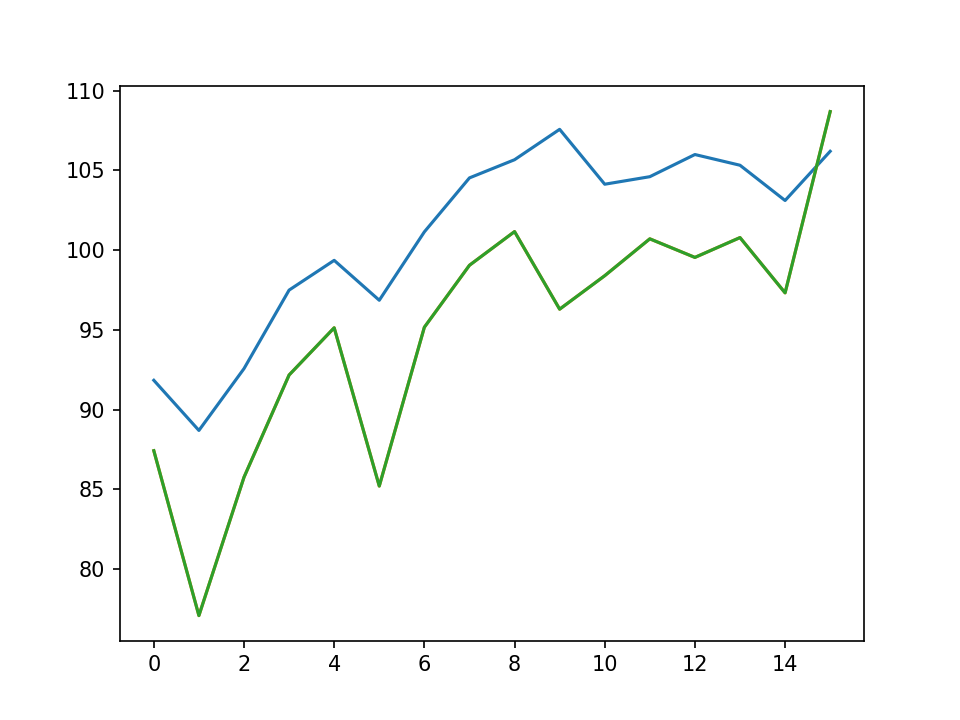

In [46]:
plt.plot(rmse_gen)

In [48]:
plt.plot(rmse_spi)